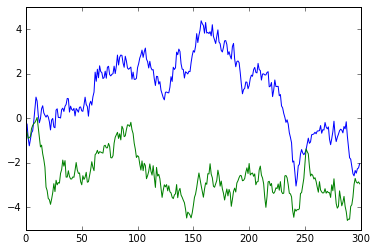

In [115]:

"""
this file aims to generate the computational result in Ahmad et al. (2016):

A STOCHASTIC PARTIAL DIFFERENTIAL EQUATION MODEL FOR
THE PRICING OF MORTGAGE-BACKED SECURITIES

and it's unfinished

Fangda Wang

9/17/2017

"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from numba import jit

T=30 # time horizon
mu=0.024 # drift of W_i
sigma=0.0115 # volatility of W_i
rho=0.35 #correlation between W_i and W_M

b1=2.7 # parameter of the Beta distribution
b2=3.05 # parameter of the Beta distribution

r0=0.06 # initial interest rate
K=0.05 # upper bound
a=0.6 # parameter of the drift of W_I
b=0.06 # paramter of the drift of W_I
sigma_I=0.25 # volatility of W_I
corr=0.35 # correlation between W_I and W_M

#step 1: get number of time points and mesh size
N_time=300 # number of time points, since 1 year =12 month, we choose 300 to track
                    # the monthly dynamic
dt=T/N_time # corresponding mesh size

#step 2a: get two BM for the market and interest rate:W_M and W_I
dW_M=np.random.normal(0, np.sqrt(dt), N_time)
W_M=np.cumsum(dW_M)
dW_I=corr * dW_M + np.sqrt(1 - corr **2) * np.random.normal(0, np.sqrt(dt), N_time)
W_I= np.cumsum(dW_I)
plt.plot(W_M, color='blue')
plt.plot(W_I, color='green')
plt.show()

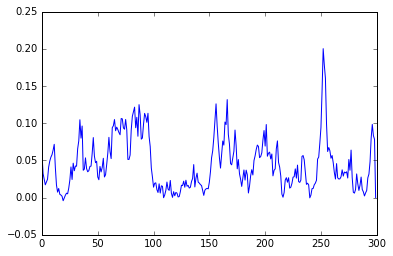

In [116]:
#step 2b: get the time path for interest rate
r_t=np.zeros(N_time)
r_t[0]=r0
for i in range(1, N_time-1):
    temp1=a * (b - r_t[i-1]) * dt
    temp2=sigma_I * np.sqrt(max(r_t[i-1], 0)) * dW_I[i-1]
    r_t[i] =r_t[i-1] + temp1 +temp2
plt.plot(r_t)
plt.show()

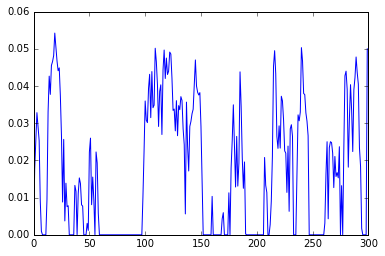

In [117]:
#step 2c: time path for lambda_t
lambda_t=np.zeros(N_time)
for i in range(N_time):
    lambda_t[i]=max(K-r_t[i], 0)
plt.plot(lambda_t)
plt.show()

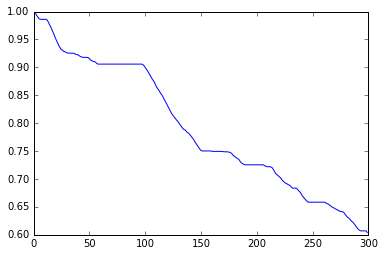

In [118]:
#step 2d: time path for Lambda_t
Lambda_t=np.zeros(N_time)
integrand=np.zeros(N_time)
for i in range(N_time):
    integrand[i]=sum(lambda_t[:i+1])*dt
for i in range(N_time):
    Lambda_t[i]=np.exp(-integrand[i])

plt.plot(Lambda_t)
plt.show()

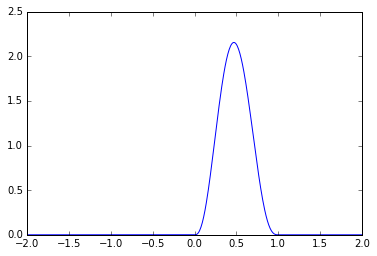

In [119]:
#step 3 generate the density function V_i for i =1, 2, ,..., N_time
#we need interpolate V_i to a fixed number of  grid points

N_grid=500
inf=-2
sup=2
span=sup-inf
xx=np.linspace(inf, sup, N_grid)
def beta(x):
    if x<0:
        return 0
    elif x>1:
        return 0
    else:
        return x**b1*(1-x)**b2
def Beta(x):
    return beta(x)/quad(beta, 0, 1)[0]
V_0=np.zeros(N_grid)
for i, j in enumerate(xx):
    V_0[i] = Beta(j)
plt.plot(xx, V_0)
plt.show()

In [120]:
#step 4: initializing
L_0def=0
L_0pay=0
L_0ref=0

In [135]:
#step 5:  useful maps

@jit(nopython=True)
def shift(f, a):
    """
    here f is the np array
    a is the shift parameter
    """
    aa=int(a*N_grid/span)
    new_f=np.zeros(N_grid)
    if aa>=0:
        for i in range(N_grid):
            if i<aa:
                new_f[i]=0
            else:
                new_f[i]=f[aa-i]
    else:
        for i in range(N_grid):
            if i<N_grid+aa:
                new_f[i]=f[-aa+i]
            else:
                new_f[i]=0
    return new_f
                
@jit(nopython=True)
def scale(f, a):
    new_f=np.zeros(N_grid)
    for i, j in enumerate(f):
        new_f[i]=a*j
    return new_f

@jit(nopython=True)
def trunc(f):
    new_f=np.zeros(N_grid)
    xx=np.linspace(inf, sup, N_grid)
    for i in range(N_grid):
        new_f[i]=f[i]*(xx[i]>=0 and xx[i]<=1)
    return new_f

@jit(nopython=True)
def quad_(f, a, b):
    temp=0.0
    aa=int((a-inf)*N_grid/span)
    bb=int((b-inf)*N_grid/span)
    for i in range(aa, bb):
        temp+=f[i]
    return temp*span/N_grid

@jit(nopython=True)
def gauss_kernel(f, t, x):
    new_f=np.zeros(N_grid)
    for i in range(N_grid):
        temp=int(((x+np.sqrt(t)*(inf+i*span/N_grid))-inf)*N_grid/span)
        if temp>=0 and temp<N_grid:
            new_f[i] = f[temp]*np.exp(-(inf+i*span/N_grid)**2/2)
        else:
            new_f[i] =0
    return new_f

@jit(nopython=True)
def gauss(f, t, x):
    return quad_(gauss_kernel(f, t, x), inf, sup)

@jit(nopython=True)
def Gauss(f, t):
    new_f=np.zeros(N_grid)
    for i in range(N_grid):
        new_f[i]=gauss(f, t, inf+i*span/N_grid)
    return new_f

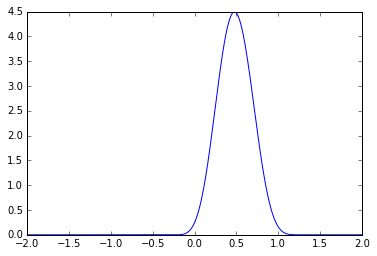

In [137]:
plt.plot(xx, Gauss(V_0, 0.016))
plt.show()

In [143]:
#step 6:  updating procedure
increment=np.zeros(N_time)
for i in range(1, N_time):
    increment[i]=sigma * rho * dW_M[i] + mu * dt

@jit(nopython=True)
def f_temp(V, incre):
    return shift(Gauss(V, sigma*np.sqrt(1-rho**2)*dt), incre)

@jit(nopython=True)
def update_L_def(L_def, V, incre):
    return L_def + quad_(f_temp(V, incre), inf, 0)

@jit(nopython=True)
def update_L_pay(L_pay, V, incre):
    return L_pay + quad_(f_temp(V, incre), 1, sup)

dLam=np.zeros(N_time)
for i in range(1, N_time):
    dLam[i]=Lambda_t[i-1] - Lambda_t[i]

@jit(nopython=True)
def update_V(V, incre, dLambda):
    return scale(trunc(f_temp(V, incre)), 1-dLambda)

@jit(nopython=True)
def update_L_ref(V, incre, dLambda):
    return dLambda * quad_(f_temp(V, incre), 0, 1)

In [144]:
# finally, updating until i=N_time
L_d=[L_0def]
L_p=[L_0pay]
L_r=[L_0ref]
V=[V_0]

for i in range(1, N_time):
    incre=increment[i-1]
    dLambda=dLam[i-1]
    L_def=L_d[i-1]
    L_pay=L_p[i-1]
    L_ref=L_r[i-1]
    v=V[i-1]
    
    L_d.append(update_L_def(L_def, v, incre))
    L_p.append(update_L_pay(L_pay, v, incre))
    V.append(update_V(v, incre, dLambda))
    L_r.append(update_L_ref(v, incre, dLambda))

L_d, L_p, L_r

([0,
  2.3876046277387735,
  2.3878635634549363,
  2.3881619455783487,
  2.3883737424939624,
  2.3885367706754272,
  2.3886606882489385,
  2.3887551152325948,
  2.3888271606377587,
  2.388882176805475,
  2.3889241924207747,
  2.3889562796180255,
  2.3889807845065776,
  2.388999498811313,
  2.389013777572006,
  2.389024646773186,
  2.389032912857753,
  2.3890392023859937,
  2.389043984417596,
  2.389047619989526,
  2.3890503835866865,
  2.3890524831742876,
  2.3890540789261583,
  2.389055292194154,
  2.389056214905655,
  2.389056916605955,
  2.3890574506182003,
  2.3890578574328836,
  2.389058167861074,
  2.389058404368653,
  2.3890585849262287,
  2.389058722640049,
  2.389058827737985,
  2.389058907942864,
  2.389058969195072,
  2.3890590159731864,
  2.389059051697482,
  2.3890590789800115,
  2.389059099815592,
  2.3890591157081076,
  2.3890591278320645,
  2.3890591370910914,
  2.389059144154957,
  2.3890591495420077,
  2.3890591536508605,
  2.389059156786455,
  2.389059159179401,
  2.

In [125]:
def tranche(a, d, x):
    if x<a:
        return 0
    elif a<=x and x<=d:
        return x-a
    else:
        return d-a

In [128]:
R=0.4 #recovery rate
discount=np.zeros(N_time) #discount rate
for i in range(N_time):
    discount[i]=0.01
    
def discounted_protection_fee(a, d, L_d):
    def protection(a, d, i):
        return tranche(a, d, (1-R)*L_d[i])-tranche(a, d, (1-R)*L_d[i-1])
    def fee(a, d, i):
        return d-a-tranche(a, d, (1-R)*L_d[i-1])
    temp1=np.zeros(N_time)
    temp2=np.zeros(N_time)
    for i in range(N_time):
        temp1[i]=protection(a, d, i)*(1+discount[i])**i
        temp2[i]=fee(a, d, i)*(1+discount[i])**i
    return sum(temp1), sum(temp2)

N_sims=2
aa=0
dd=0.03
Protection=[]
Fee=[]

for sim in range(N_sims):
    L=L_d
    dpf=discounted_protection_fee(aa, dd, L)
    Protection.append(dpf[0])
    Fee.append(dpf[1])

s=sum(Protection)/sum(Fee)

In [131]:
s

0.0099009900990099549